# <font color=darkred> Advanced Machine Learning for Prediction of House Prices
    
- A POC project to illustrate use of advanced ML techniques to efficiently model prices of any product/service. 

## <font color=darkblue>Business Understanding and Problem Description:
A US-based housing company has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. 
The company is looking at prospective properties to buy to enter the market.

### <font color=darkblue> Our Job:

We are required to build a regression model using advanced techniques like _Iterative Imputation_ and _Transformation_ for data wrangling; and _Ridge/Lasso/ElasticNet Regularisation_ for modelling in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


<img src="https://ejournalz.com/wp-content/uploads/2018/08/Real-estate-Prices.jpg"
     alt="Image House" width="33%"
      />

### <font color=darkblue> Project Expectations:

- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

The optimal values of hyperparameters can be determined through _Grid Search Cross Validation._

### <font color=darkblue> Primary Business Goal of the Project:

We are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for the management to understand the pricing dynamics of a new market.

### <font color=darkblue> Secondary Goal:

Deploy this model as an interactive Web-App and provide it as a service - _House Price Estimator._

### <font color=darkblue> Business Use Cases: 

The steps employed can be easily replicated in building stable models for competitive market pricing of products given its features. 
For example, this model can be used to come up with an intrinsic market value of OES as a product and help in deciding it's pricing in the current market. 
The same can also be applied in feature-relevance-forecasting and other types of business analysis. 

## <font color=darkred> Analysis Approach:</font>
- ### [Data Inspection](#di): We shall first begin with inspecting the data we have, do necessary conversions and perform missing value analysis on it.

- ### [Data Cleaning](#dc): Missing Value analysis : Imputation using techniques like KNNImputer as well as using business intuition.

- ### [EDA](#eda): We will now proceed to do detailed bivariate visualizations and get a feel of how each feature behaves with respect to others hence getting an idea of underlying correlations within our dataset, also, we will select out features which we shall use for evaluating our model results later.

- ### [Feature Engineering](#fe): Now, we shall transform our features to gaussian distributions, add new combined and polynomial features and take care of outliers.

- ### Next we will proceed with [Data Preparation for Modelling](#modelling),dummification of categorical variables and standardization of numerical attributes.

- ### Next we will do [Ridge Regularization](#ridge) and observe the performance.

- ### Finally , we shall perform [Lasso Regularization](#lasso) and see if its any better as compared to Ridge.



## <font color=darkred>First Steps</font>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr



from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<a id='di'></a>
## <font color=darkred>DATA INSPECTION</font>


In [2]:
complete_data = pd.read_csv("train.csv")

In [3]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- #### <font color=darkblue>We have been provided with 79 features and 2919 records</font>


In [4]:
# Drop Id column
complete_data.drop("Id", axis = 1, inplace = True)

<a id='dc'></a>
## <font color=darkred>DATA CLEANING</font>


- ### <font color=darkred>Missing Value Analysis</font>


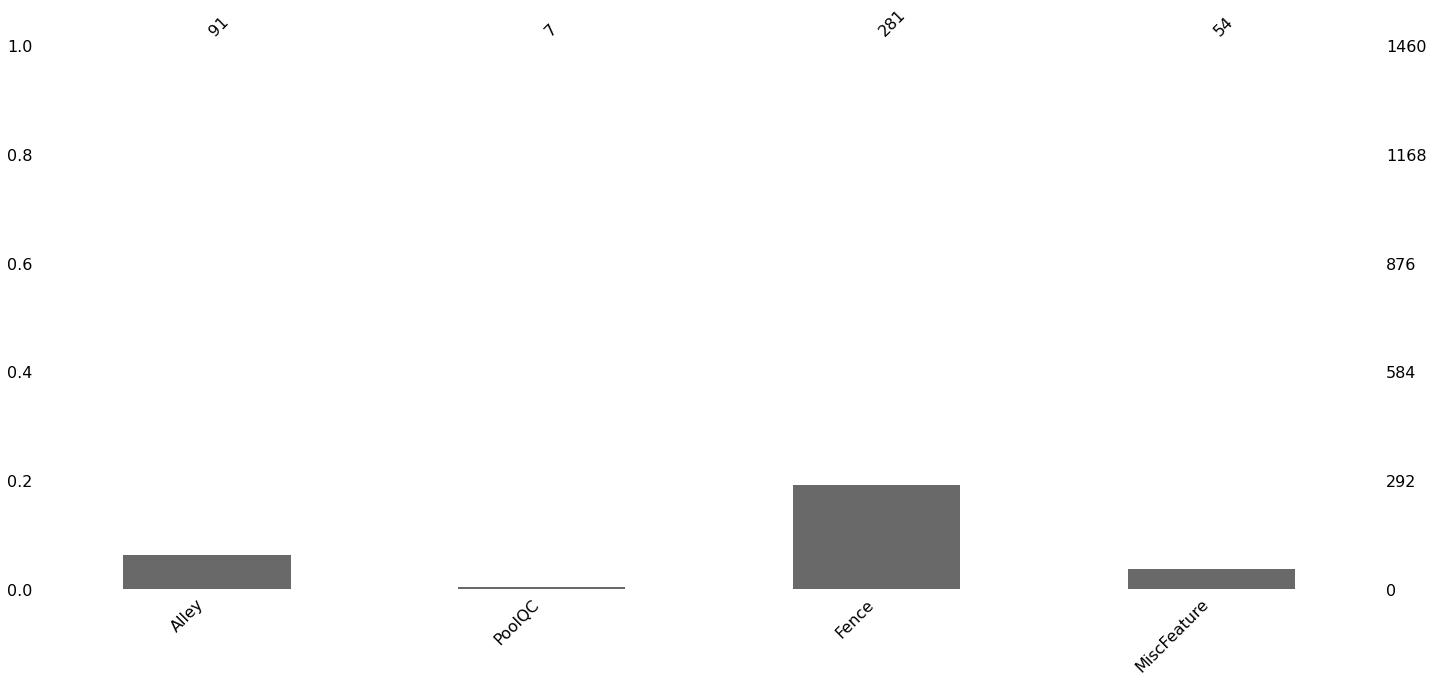

In [5]:
import missingno as msno
msno.bar(complete_data.loc[:,complete_data.isna().mean()>0.5])

- #### <font color=darkblue>Dropping columns with more than 45% missing values (6 features) as these are not statistically significant for our analysis</font>


In [6]:
complete_data = complete_data.loc[:, complete_data.isnull().mean()<0.5]

### <font color=darkblue>Now let's take care of all the other columns with missing values</font>


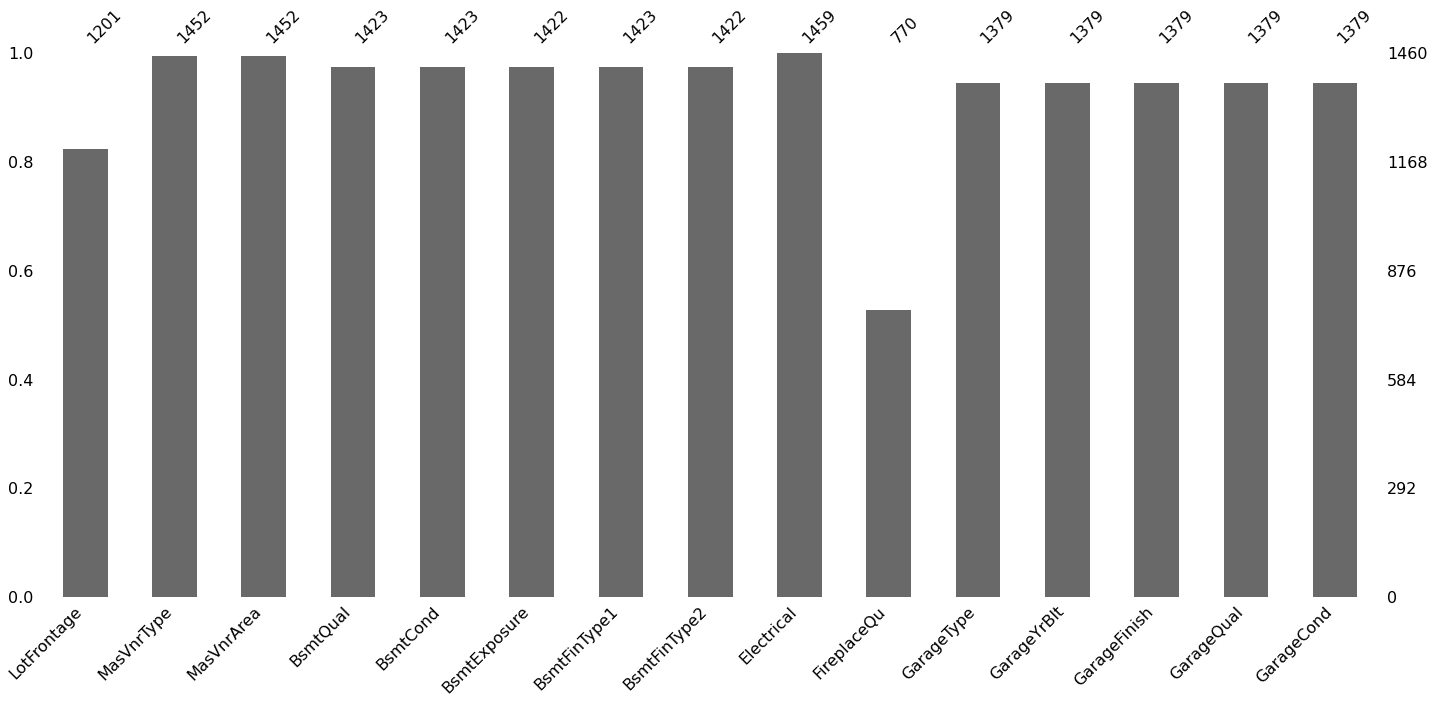

In [7]:
import missingno as msno
msno.bar(complete_data.loc[:,complete_data.isna().mean()!=0])

### <font color=darkblue>Column-wise missing value analysis</font>

We impute them  by proceeding sequentially  through features with missing values 

- **LotFrontage** : We can let **KNN Imputer** decide the ideal value which is most similar of houses of the same kind within the dataset.

In [8]:
from sklearn.impute import KNNImputer

kt = KNNImputer()
kt.fit_transform(complete_data[['LotFrontage']])

complete_data[['LotFrontage']] = kt.fit_transform(complete_data[['LotFrontage']])

- **GarageType, GarageFinish, GarageQual and GarageCond** : Missing data here will mostly mean that the home does not have a garage, hence replacing missing data with 'None'.

In [9]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    complete_data[col] = complete_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [10]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    complete_data[col] = complete_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [11]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    complete_data[col] = complete_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [12]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    complete_data[col] = complete_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [13]:
complete_data["MasVnrType"] = complete_data["MasVnrType"].fillna("None")
complete_data["MasVnrArea"] = complete_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [14]:
complete_data['MSZoning'] = complete_data['MSZoning'].fillna(complete_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature, the sentitivity towards target variable is almost 0, all records are "AllPub", except for one "NoSeWa"  and 2 NA  and hence **this feature won't help in predictive modelling**. We can then safely  remove it.


In [15]:
complete_data = complete_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [16]:
complete_data["Functional"] = complete_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [17]:
complete_data['Electrical'] = complete_data['Electrical'].fillna(complete_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [18]:
complete_data['KitchenQual'] = complete_data['KitchenQual'].fillna(complete_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [19]:
complete_data['Exterior1st'] = complete_data['Exterior1st'].fillna(complete_data['Exterior1st'].mode()[0])
complete_data['Exterior2nd'] = complete_data['Exterior2nd'].fillna(complete_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [20]:
complete_data['SaleType'] = complete_data['SaleType'].fillna(complete_data['SaleType'].mode()[0])

- **MSSubClass** : NA most likely means No building class. We can replace missing values with None


In [21]:
complete_data['MSSubClass'] = complete_data['MSSubClass'].fillna("None")

- **FireplaceQu** : NA most likely means No Fireplace.

In [22]:
complete_data["FireplaceQu"] = complete_data["FireplaceQu"].fillna("No")

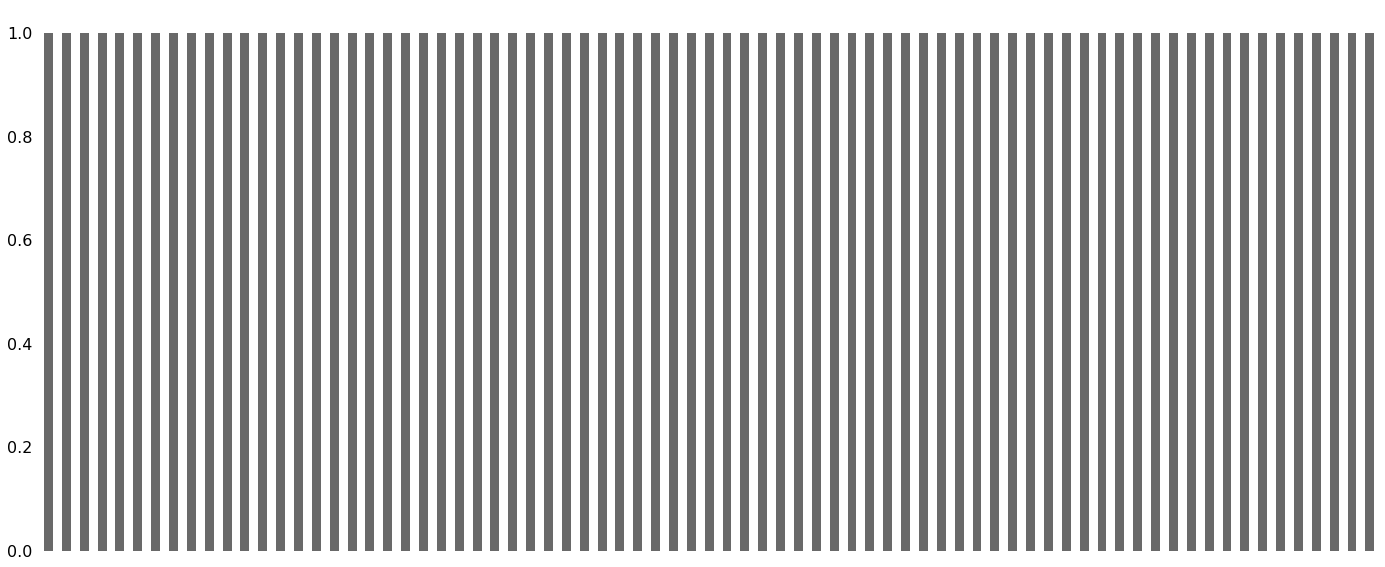

In [23]:
import missingno as msno
msno.bar(complete_data)

- #### <font color=darkblue>All missing values treated.

In [24]:
complete_data.to_csv('houses_nonan.csv',index=False)

<a id='fe'></a>

- ### <font color=darkred>Feature Engineering

- #### <font color=darkblue>Removing 'any houses with more than 4000 square feet' from the dataset in line with what the author of the dataset recommends. 


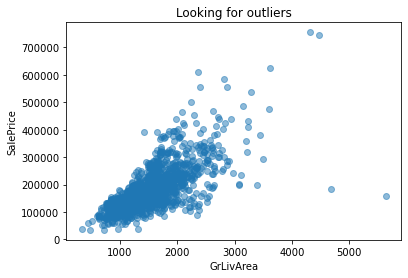

In [25]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(complete_data.GrLivArea, complete_data.SalePrice, alpha=0.5)
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

complete_data = complete_data[complete_data.GrLivArea < 4000]

- #### <font color=darkblue>Transforming our Target feature, which has positive skew 


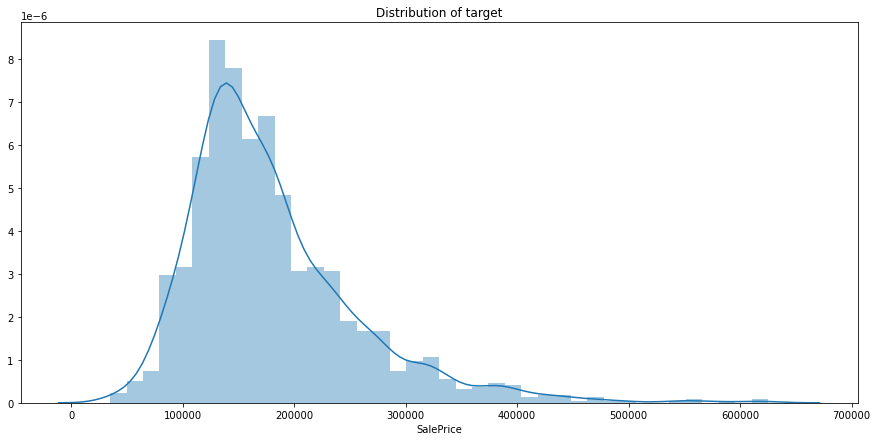

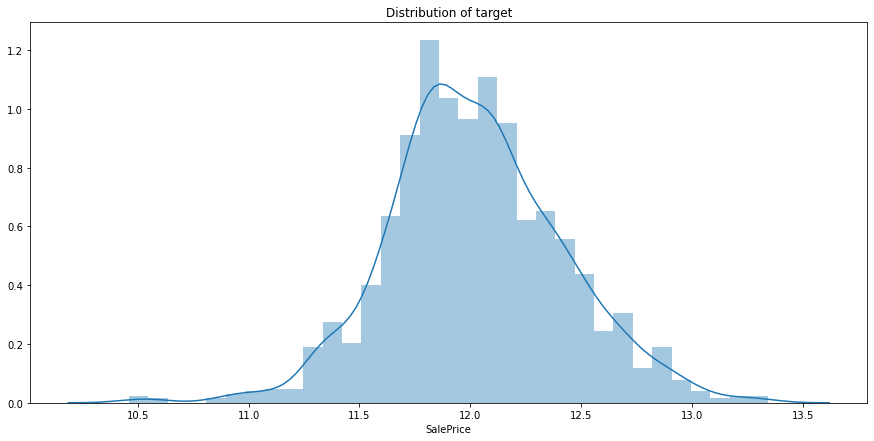

In [26]:
plt.figure(figsize=(15,7))
sns.distplot(complete_data.SalePrice)
plt.title("Distribution of target")
plt.xlabel("SalePrice")
plt.show()

# Log transform the target
complete_data.SalePrice = np.log1p(complete_data.SalePrice)
y = complete_data.SalePrice

plt.figure(figsize=(15,7))
sns.distplot(complete_data.SalePrice)
plt.title("Distribution of target")
plt.xlabel("SalePrice")
plt.show()


- #### <font color=darkblue>Transforming Temporal Variables (Eg: Datetime Variables)
    <br/>
From the Dataset we have 4 year variables. We have extract information from the datetime variables like no of years or no of days. One example in this specific scenario can be difference in years between the year the house was built and the year the house was sold. 

In [27]:
for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
       
    complete_data[feature]=complete_data['YrSold']-complete_data[feature]

- #### <font color=darkblue> Transforming some Misrepresented Numerical variables to Categorical

In [28]:
# Some numerical features are actually really categories
complete_data = complete_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

- #### <font color=darkblue>Label Encoding Ordinal Categorical features

In [29]:
complete_data = complete_data.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

- #### <font color=darkblue>Adding new features

##### <font color=darkblue>Combining features and making new ones

In [30]:
# Total SF for house (incl. basement)
complete_data["AllSF"] = complete_data["GrLivArea"] + complete_data["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
complete_data["AllFlrsSF"] = complete_data["1stFlrSF"] + complete_data["2ndFlrSF"]
# Total SF for porch
complete_data["AllPorchSF"] = complete_data["OpenPorchSF"] + complete_data["EnclosedPorch"] + complete_data["3SsnPorch"] + complete_data["ScreenPorch"]

In [31]:
# Overall quality of the house
complete_data["OverallGrade"] = complete_data["OverallQual"] * complete_data["OverallCond"]
# Overall quality of the exterior
complete_data["ExterGrade"] = complete_data["ExterQual"] * complete_data["ExterCond"]

##### <font color=darkblue>Creating polynomial features of the most correlated features to capture non-linearity in data

In [32]:
# Find most important features relative to target
print("Find most important features relative to Sales Price")
corr = complete_data.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to Sales Price
SalePrice        1.000
OverallQual      0.819
AllSF            0.817
AllFlrsSF        0.729
GrLivArea        0.719
ExterQual        0.681
GarageCars       0.680
KitchenQual      0.667
GarageArea       0.655
TotalBsmtSF      0.642
1stFlrSF         0.614
OverallGrade     0.604
FullBath         0.591
ExterGrade       0.587
FireplaceQu      0.547
TotRmsAbvGrd     0.533
Fireplaces       0.487
HeatingQC        0.474
MasVnrArea       0.426
BsmtFinSF1       0.383
LotFrontage      0.343
WoodDeckSF       0.331
OpenPorchSF      0.327
HalfBath         0.311
2ndFlrSF         0.307
PavedDrive       0.306
LotArea          0.259
BsmtFullBath     0.239
BsmtUnfSF        0.223
BedroomAbvGr     0.204
AllPorchSF       0.199
Functional       0.136
ScreenPorch      0.124
Street           0.058
3SsnPorch        0.056
ExterCond        0.051
PoolArea         0.041
BsmtFinSF2       0.006
BsmtHalfBath    -0.015
MiscVal         -0.020
YrSold          -0.034
Over

In [33]:
# Create new features
# 3* Polynomials on the top 10 existing features
complete_data["OverallQual-s2"] = complete_data["OverallQual"] ** 2
complete_data["OverallQual-s3"] = complete_data["OverallQual"] ** 3
complete_data["OverallQual-Sq"] = np.sqrt(complete_data["OverallQual"])

complete_data["AllSF-2"] = complete_data["AllSF"] ** 2
complete_data["AllSF-3"] = complete_data["AllSF"] ** 3
complete_data["AllSF-Sq"] = np.sqrt(complete_data["AllSF"])

complete_data["AllFlrsSF-2"] = complete_data["AllFlrsSF"] ** 2
complete_data["AllFlrsSF-3"] = complete_data["AllFlrsSF"] ** 3
complete_data["AllFlrsSF-Sq"] = np.sqrt(complete_data["AllFlrsSF"])

complete_data["GrLivArea-2"] = complete_data["GrLivArea"] ** 2
complete_data["GrLivArea-3"] = complete_data["GrLivArea"] ** 3
complete_data["GrLivArea-Sq"] = np.sqrt(complete_data["GrLivArea"])

complete_data["ExterQual-2"] = complete_data["ExterQual"] ** 2
complete_data["ExterQual-3"] = complete_data["ExterQual"] ** 3
complete_data["ExterQual-Sq"] = np.sqrt(complete_data["ExterQual"])

complete_data["GarageCars-2"] = complete_data["GarageCars"] ** 2
complete_data["GarageCars-3"] = complete_data["GarageCars"] ** 3
complete_data["GarageCars-Sq"] = np.sqrt(complete_data["GarageCars"])

complete_data["KitchenQual-2"] = complete_data["KitchenQual"] ** 2
complete_data["KitchenQual-3"] = complete_data["KitchenQual"] ** 3
complete_data["KitchenQual-Sq"] = np.sqrt(complete_data["KitchenQual"])

In [34]:
# Separating numerical features (minus the target) from categorical features
categorical_features = complete_data.select_dtypes(include = ["object"]).columns
numerical_features = complete_data.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = complete_data[numerical_features]
train_cat = complete_data[categorical_features]

Numerical features : 70
Categorical features : 30


In [35]:
categorical_features

Index(['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'CentralAir', 'Electrical', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

- #### <font color=darkblue> Handling Skewness - Treating Outliers

In [36]:
# Log transform of the skewed numerical features to lessen impact of outliers

skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

54 skewed numerical features to log transform


D:\ASH\Study\Softwares\Anaconda\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<a id='modelling'></a>

- ### <font color=darkred>Data Preparation for Modelling


##### <font color=darkblue>Dummification of Categorical Features

In [37]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat,drop_first=True)

##### <font color=darkblue>Train-Validation Split

In [38]:
complete_data = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(complete_data.shape[1]))

# Partition the dataset in train & validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(complete_data, y, test_size = 0.3, random_state = 42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 270
X_train : (1019, 270)
X_test : (437, 270)
y_train : (1019,)
y_test : (437,)


##### <font color=darkblue>Standardization (Scaling) of Numerical Features

In [39]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

D:\ASH\Study\Softwares\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\ASH\Study\Softwares\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


##### <font color=darkblue>Definition of Evaluation Metric : 10 Fold CV : RMSE

In [40]:
# Define evaluation metric : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

<a id='ridge'></a>

### <font color=darkblue>Ridge Regularization


Regularization is a very useful method to handle 

- Collinearity, 
- Filter out noise from data, and 
- Prevent overfitting. 

The concept behind regularization is to introduce an additional error term to penalize extreme parameter weights.
Ridge regression is an L2 penalized model where we simply add the squared sum of the weights to our cost function.

Coarse Tuned Alpha : 10.0
Fine Tuned Alpha : 14.0
Ridge RMSE on Training set : 0.11257757396816608
Ridge RMSE on Test set : 0.12037902866654535


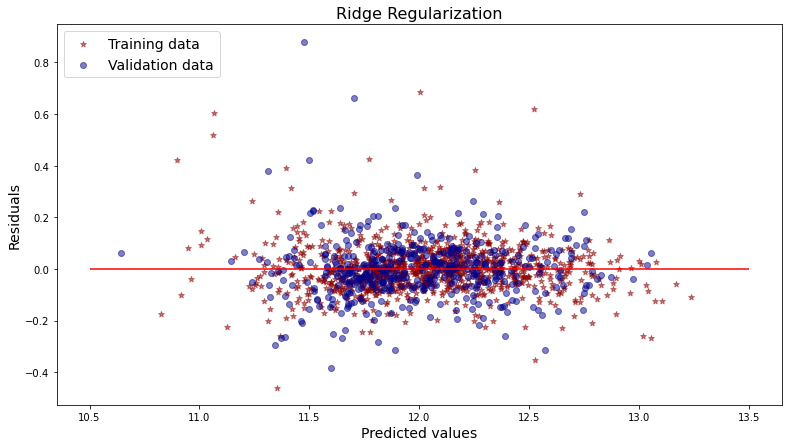

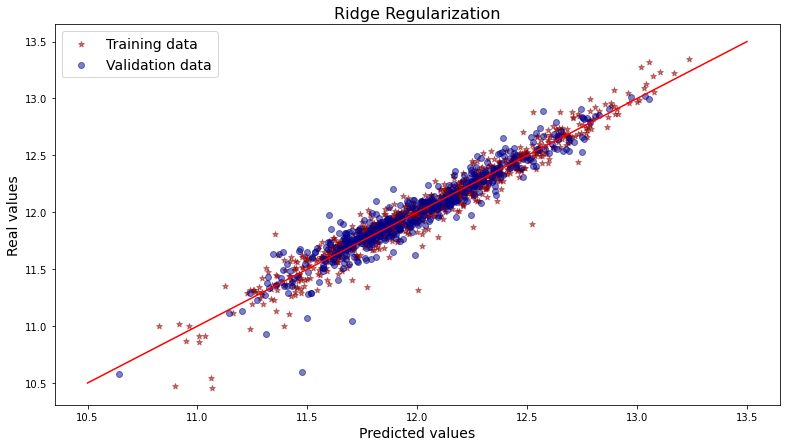

Ridge picked 267 features and eliminated the other 3 features


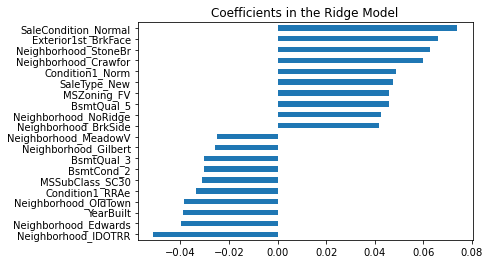

In [41]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Coarse Tuned Alpha :", alpha)

ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Fine Tuned Alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.figure(figsize=(13,7))
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "darkred", marker = "*", alpha=0.5, label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "darkblue", alpha=0.5, label = "Validation data")
plt.title("Ridge Regularization",fontsize=16)
plt.xlabel("Predicted values",fontsize=14)
plt.ylabel("Residuals",fontsize=14)
plt.legend(loc = "upper left",fontsize=14)
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(13,7))
plt.scatter(y_train_rdg, y_train, c = "darkred", alpha=0.5, marker = "*", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "darkblue", alpha=0.5, label = "Validation data")
plt.title("Ridge Regularization",fontsize=16)
plt.xlabel("Predicted values",fontsize=14)
plt.ylabel("Real values",fontsize=14)
plt.legend(loc = "upper left",fontsize=14)
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

##### Inferences:
- RMSE results are really good and test results are also simliar since we've added regularization. 
- The very small difference between training and test results indicate that we eliminated most of the overfitting. Visually, the graphs seem to confirm that idea.
- Ridge used almost all of the existing features.

<a id='lasso'></a>

### <font color=darkblue>Lasso Regularization


LASSO stands for Least Absolute Shrinkage and Selection Operator. 
- In this regularization method, we simply replace the square of the weights by the sum of the absolute value of the weights. 
- In contrast to L2 regularization, L1 regularization yields sparse feature vectors : most feature weights will be zero. 
- Sparsity can be useful in practice if we have a high dimensional dataset with many features that are irrelevant.
- Lasso helps much better in scenarios where feature selection is required, as compared to Ridge.

Coarse Tuned Alpha : 0.0006
Fine Tuned Alpha : 0.0006
Lasso RMSE on Training set : 0.11129198498421977
Lasso RMSE on Test set : 0.12130746721389399


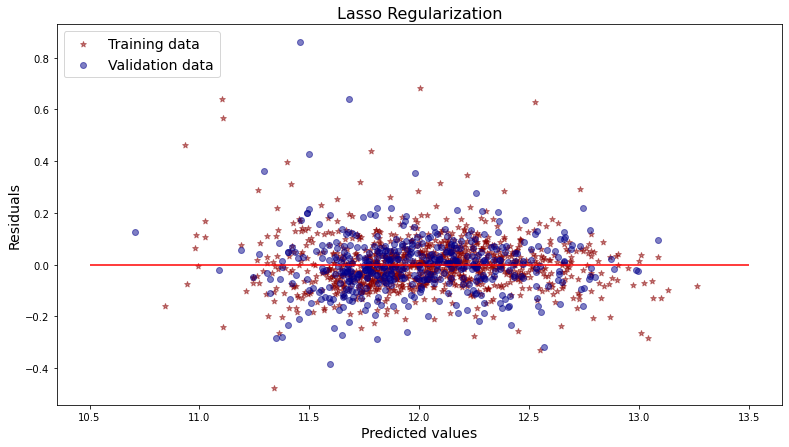

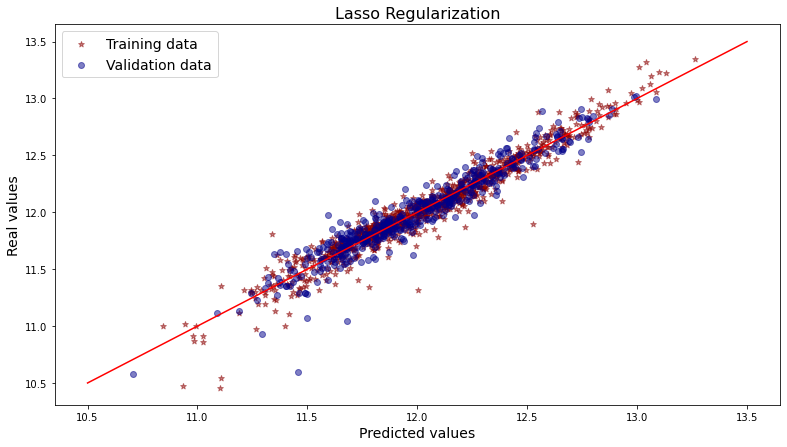

Lasso picked 96 features and eliminated the other 174 features


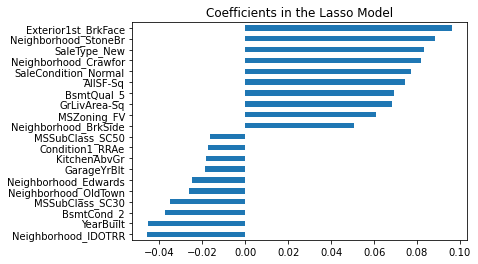

In [42]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Coarse Tuned Alpha :", alpha)

lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Fine Tuned Alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Plot residuals
plt.figure(figsize=(13,7))
plt.scatter(y_train_las, y_train_las - y_train, c = "darkred", marker = "*", alpha=0.5, label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "darkblue", alpha=0.5, label = "Validation data")
plt.title("Lasso Regularization",fontsize=16)
plt.xlabel("Predicted values",fontsize=14)
plt.ylabel("Residuals",fontsize=14)
plt.legend(loc = "upper left",fontsize=14)
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(13,7))
plt.scatter(y_train_las, y_train, c = "darkred", alpha=0.5, marker = "*", label = "Training data")
plt.scatter(y_test_las, y_test, c = "darkblue", alpha=0.5, label = "Validation data")
plt.title("Lasso Regularization",fontsize=16)
plt.xlabel("Predicted values",fontsize=14)
plt.ylabel("Real values",fontsize=14)
plt.legend(loc = "upper left",fontsize=14)
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

##### Inferences:
- RMSE results are better as compared to Ridge on Train set, and performance on test set is only slightly better in the case of Ridge.
- Lasso is able to capture almost similar performance as Ridge with just 35% all of the total number of features. (96/270)